# 00b - Preprocessing: Hotspot Name Heuristic

Create a labeled dataset using hotspot names as indicators of wetland habitats.

**Goal:** Label checklists as 'wetland' or 'non-wetland' based on hotspot names.

**Steps:**
1. Load eBird data with LOCALITY ID
2. Load hotspot names from ebird_hotspots.csv
3. Define wetland/non-wetland keywords
4. Match checklists to hotspots and label based on name
5. Filter to only include hotspot-based checklists
6. Save labeled dataset

## Setup

In [35]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Add backbone to path
project_root = Path.cwd().parent.parent.parent
sys.path.insert(0, str(project_root))

from src.data import load_ebird_data

print(f"Project root: {project_root}")
print(f"Current project: {Path.cwd().parent.name}")

Project root: c:\Users\Arnav\Documents\Python Scripts\bird embeddings
Current project: wetland_prediction


## 1. Load eBird Data (with LOCALITY ID)

In [36]:
# Load Kerala eBird data - need LOCALITY ID column
data_path = project_root / 'data' / 'raw' / 'ebd_IN-KL_smp_relSep-2025.txt'

print(f'Loading eBird data from: {data_path}')
print('This may take a few minutes...\n')

# Load with LOCALITY ID included using loader function
columns_to_load = [
    'COMMON NAME',
    'SAMPLING EVENT IDENTIFIER',
    'LOCALITY',
    'LOCALITY ID',
    'LOCALITY TYPE',
    'LATITUDE',
    'LONGITUDE',
    'OBSERVATION DATE'
]

df = load_ebird_data(str(data_path), columns=columns_to_load, nrows=1000000)

print(f'\n✓ Loaded {len(df):,} observations')
print(f'  Unique checklists: {df["SAMPLING EVENT IDENTIFIER"].nunique():,}')
print(f'  Unique species: {df["COMMON NAME"].nunique():,}')
print(f'  Unique localities: {df["LOCALITY ID"].nunique():,}')
print(f'\nLocality types:')
print(df['LOCALITY TYPE'].value_counts())

Loading eBird data from: c:\Users\Arnav\Documents\Python Scripts\bird embeddings\data\raw\ebd_IN-KL_smp_relSep-2025.txt
This may take a few minutes...

✓ Loaded eBird data from: ebd_IN-KL_smp_relSep-2025.txt
  Rows: 1,000,000
  Columns: 8
  (Limited to first 1,000,000 rows)

✓ Loaded 1,000,000 observations
  Unique checklists: 75,093
  Unique species: 680
  Unique localities: 14,880

Locality types:
LOCALITY TYPE
H    561551
P    438449
Name: count, dtype: int64


## 2. Load Hotspot Data

In [37]:
# Load hotspot names
hotspot_path = Path('../data/raw/ebird_hotspots.csv')

print(f'Loading hotspot data from: {hotspot_path}')
hotspots_df = pd.read_csv(hotspot_path)

print(f'\n✓ Loaded {len(hotspots_df):,} hotspots')
print(f'\nColumns: {list(hotspots_df.columns)}')
print(f'\nSample hotspot names:')
print(hotspots_df['Hotspot name'].head(10).to_string(index=False))

Loading hotspot data from: ..\data\raw\ebird_hotspots.csv

✓ Loaded 25,050 hotspots

Columns: ['LocID', 'Country', 'Subnat1', 'Subnat2', 'Latitude', 'Longitude', 'Hotspot name', 'Last visited', 'Species']

Sample hotspot names:
                        Hogenakkal Falls
(9.668, 76.322)Homeyard Karuvayil Bhagom
                                117,23,9
                                117,24,9
                                117,25,1
                                118,23,2
                                118,25,6
                        11th HB--Yercaud
                     1300 Chain PWD Camp
                               15th Mile


In [38]:
# Filter to Kerala hotspots only
kerala_hotspots = hotspots_df[hotspots_df['Subnat1'] == 'IN-KL'].copy()

print(f'Kerala hotspots: {len(kerala_hotspots):,}')
print(f'\nSample Kerala hotspot names:')
print(kerala_hotspots['Hotspot name'].head(20).to_string(index=False))

Kerala hotspots: 3,973

Sample Kerala hotspot names:
       (9.668, 76.322)Homeyard Karuvayil Bhagom
                                       117,23,9
                                       117,24,9
                                       117,25,1
                                       118,23,2
                                       118,25,6
1st Stream Birding Patch, Ring road, Malampuzha
         1st river feeding Malampuzha dam, Kava
                            26th mile [42.18.9]
                       38.29.1 (ptr kochupampa)
                             38.29.6 Kochupamba
                           71,26,6 PKM-Anappady
                           71,27,1 PKM-Anappady
                           900 woods eco resort
                         A U P School, Mulleria
                                   AUPS, Kuntar
                       AXIS College-Thaloopadam
                          Aalumpeedika Wetlands
                Aanakkallu--Kuzhimavu [39.23.5]
              Aanakkayam--near Coop

## 3. Define Wetland and Non-Wetland Keywords

**Wetland indicators:**
- Water bodies: lake, pond, reservoir, dam, backwater, lagoon, wetland
- Malayalam: kere, kulam, poyka, vembanad, kayaloram
- Types: river, stream, creek, canal, marsh, swamp

**Non-wetland indicators:**
- Terrestrial: forest, jungle, grassland, meadow, hill, mountain, peak
- Malayalam: mala, vanam, kadu

In [39]:
# Define keyword lists
WETLAND_KEYWORDS = [
    # English water bodies
    'lake', 'pond', 'reservoir', 'dam', 'wetland', 'lagoon', 'backwater',
    'river', 'stream', 'creek', 'canal', 'marsh', 'swamp', 'estuary',
    'waterfront', 'waterside', 'riverside', 'lakeside',
    
    # Malayalam/local terms
    'kere', 'kulam', 'poyka', 'kayaloram', 'vembanad', 'kayal',
    'kadavu', 'thodu', 'puzha', 'aaru',
    
    # Specific wetland features
    'falls', 'waterfall', 'cascade', 'rapids',
    'mangrove', 'mudflat', 'tidal'
]

NON_WETLAND_KEYWORDS = [
    # Terrestrial habitats
    'forest', 'jungle', 'woods', 'woodland', 'tree',
    'grassland', 'meadow', 'field', 'plains', 'savanna',
    'hill', 'hilltop', 'mountain', 'peak', 'valley', 'slope',
    'garden', 'park', 'grove',
    
    # Malayalam/local terms
    'mala', 'vanam', 'kadu', 'thoppu', 'padam',
    
    # Others
    'farm', 'plantation', 'estate', 'campus', 'compound'
]

print(f'Wetland keywords: {len(WETLAND_KEYWORDS)}')
print(f'Non-wetland keywords: {len(NON_WETLAND_KEYWORDS)}')
print(f'\nSample wetland keywords: {WETLAND_KEYWORDS[:10]}')
print(f'Sample non-wetland keywords: {NON_WETLAND_KEYWORDS[:10]}')

Wetland keywords: 35
Non-wetland keywords: 29

Sample wetland keywords: ['lake', 'pond', 'reservoir', 'dam', 'wetland', 'lagoon', 'backwater', 'river', 'stream', 'creek']
Sample non-wetland keywords: ['forest', 'jungle', 'woods', 'woodland', 'tree', 'grassland', 'meadow', 'field', 'plains', 'savanna']


## 4. Classify Hotspots by Name

In [40]:
def classify_hotspot_name(name):
    """
    Classify hotspot as wetland, non-wetland, or unclear based on name.
    Uses word boundary matching to avoid partial word matches.
    
    Returns:
        'wetland', 'non-wetland', or 'unclear'
    """
    if pd.isna(name):
        return 'unclear'
    
    name_lower = name.lower()
    
    # Check for wetland keywords with word boundaries
    wetland_matches = []
    for kw in WETLAND_KEYWORDS:
        # Use regex word boundary \b to match whole words only
        pattern = r'\b' + re.escape(kw) + r'\b'
        if re.search(pattern, name_lower):
            wetland_matches.append(kw)
    
    # Check for non-wetland keywords with word boundaries
    non_wetland_matches = []
    for kw in NON_WETLAND_KEYWORDS:
        pattern = r'\b' + re.escape(kw) + r'\b'
        if re.search(pattern, name_lower):
            non_wetland_matches.append(kw)
    
    # If both or neither, unclear
    if (wetland_matches and non_wetland_matches) or (not wetland_matches and not non_wetland_matches):
        return 'unclear'
    
    # If only wetland keywords found
    if wetland_matches:
        return 'wetland'
    
    # If only non-wetland keywords found
    if non_wetland_matches:
        return 'non-wetland'
    
    return 'unclear'

# Apply classification to Kerala hotspots
kerala_hotspots['habitat_type'] = kerala_hotspots['Hotspot name'].apply(classify_hotspot_name)

print('Hotspot classification results:')
print(kerala_hotspots['habitat_type'].value_counts())
print(f'\nPercentages:')
print(kerala_hotspots['habitat_type'].value_counts(normalize=True) * 100)

Hotspot classification results:
habitat_type
unclear        3344
non-wetland     391
wetland         238
Name: count, dtype: int64

Percentages:
habitat_type
unclear        84.168135
non-wetland     9.841430
wetland         5.990435
Name: proportion, dtype: float64


In [41]:
# Show sample wetland hotspots
wetland_hotspots = kerala_hotspots[kerala_hotspots['habitat_type'] == 'wetland']
print(f'Sample WETLAND hotspots ({len(wetland_hotspots)} total):')
print(wetland_hotspots['Hotspot name'].head(15).to_string(index=False))

Sample WETLAND hotspots (238 total):
1st Stream Birding Patch, Ring road, Malampuzha
         1st river feeding Malampuzha dam, Kava
                                   Akkulam Lake
                                 Anayiragal Dam
                                Anodi Palla Dam
                  Aranmula -Nalkalikkal Wetland
                           Aravathvayal Wetland
                                   Arayi Kadavu
                             Arogyampadavu Lake
                           Aruvikkara Reservoir
                      Athirappilly--Water Falls
                       Banasura Sagar Reservoir
  Bharatha Puzha Riverbed, Near Mayannur Bridge
                 Bharathappuzha River Check Dam
                           Bhavani River Bridge


In [42]:
# Show sample non-wetland hotspots
non_wetland_hotspots = kerala_hotspots[kerala_hotspots['habitat_type'] == 'non-wetland']
print(f'Sample NON-WETLAND hotspots ({len(non_wetland_hotspots)} total):')
print(non_wetland_hotspots['Hotspot name'].head(15).to_string(index=False))

Sample NON-WETLAND hotspots (391 total):
                              900 woods eco resort
                            AchanKovil Road Forest
            Achankovil Forest Division--Achankovil
               Achankovil Forest Division--Chittar
             Achankovil Forest Division--Devarmala
               Achankovil Forest Division--Kanayar
            Achankovil Forest Division--Kottavasal
          Achankovil Forest Division--Priya Estate
            Achankovil Forest Division--Toovalmala
Achankovil Forest Division-Nedumkulam CS, Kalla...
              Achankovil Forest Divison--Pulikayam
                                     Ahalia Campus
         Ahalia Campus--Sculpture Park and Hillock
            Alexandria Estate Sub-cell No. 71,22,5
                         All Saints College Campus


## 5. Match Checklists to Hotspots and Label

In [43]:
# Create mapping from LOCALITY ID to habitat type
hotspot_labels = kerala_hotspots.set_index('LocID')['habitat_type'].to_dict()

print(f'Created label mapping for {len(hotspot_labels):,} hotspots')

Created label mapping for 3,973 hotspots


In [44]:
# Get unique checklists with their locality info
checklist_info = df.groupby('SAMPLING EVENT IDENTIFIER').agg({
    'COMMON NAME': 'count',  # Species count
    'LOCALITY': 'first',
    'LOCALITY ID': 'first',
    'LOCALITY TYPE': 'first',
    'LATITUDE': 'first',
    'LONGITUDE': 'first',
    'OBSERVATION DATE': 'first'
}).reset_index()

checklist_info.columns = [
    'SAMPLING EVENT IDENTIFIER', 'species_count', 'LOCALITY', 
    'LOCALITY_ID', 'LOCALITY_TYPE', 'LATITUDE', 'LONGITUDE', 'OBSERVATION_DATE'
]

print(f'Total checklists: {len(checklist_info):,}')

Total checklists: 75,093


In [45]:
# Map hotspot labels to checklists
checklist_info['habitat_type'] = checklist_info['LOCALITY_ID'].map(hotspot_labels)

# Show distribution
print('Checklist classification:')
print(checklist_info['habitat_type'].value_counts(dropna=False))
print(f'\nPercentages:')
print(checklist_info['habitat_type'].value_counts(normalize=True, dropna=False) * 100)

Checklist classification:
habitat_type
NaN            41328
unclear        28818
non-wetland     2845
wetland         2102
Name: count, dtype: int64

Percentages:
habitat_type
NaN            55.035756
unclear        38.376413
non-wetland     3.788635
wetland         2.799196
Name: proportion, dtype: float64


In [46]:
# Filter to only wetland and non-wetland (exclude unclear and non-hotspot checklists)
labeled_checklists = checklist_info[
    checklist_info['habitat_type'].isin(['wetland', 'non-wetland'])
].copy()

print(f'Filtered to labeled hotspot checklists:')
print(f'  Total: {len(labeled_checklists):,}')
print(f'  Wetland: {(labeled_checklists["habitat_type"] == "wetland").sum():,}')
print(f'  Non-wetland: {(labeled_checklists["habitat_type"] == "non-wetland").sum():,}')
print(f'\nRemoved {len(checklist_info) - len(labeled_checklists):,} checklists (unclear or non-hotspot)')

Filtered to labeled hotspot checklists:
  Total: 4,947
  Wetland: 2,102
  Non-wetland: 2,845

Removed 70,146 checklists (unclear or non-hotspot)


## 6. Create Balanced Dataset (Optional)

In [47]:
# Check class balance
wetland_count = (labeled_checklists['habitat_type'] == 'wetland').sum()
non_wetland_count = (labeled_checklists['habitat_type'] == 'non-wetland').sum()

print(f'Original labeled dataset:')
print(f'  Wetland: {wetland_count:,}')
print(f'  Non-wetland: {non_wetland_count:,}')
print(f'  Ratio: 1:{non_wetland_count/wetland_count:.2f}')

# Create balanced dataset if needed
if non_wetland_count > 2 * wetland_count or wetland_count > 2 * non_wetland_count:
    print(f'\nCreating balanced dataset...')
    
    min_count = min(wetland_count, non_wetland_count)
    
    wetland_df = labeled_checklists[labeled_checklists['habitat_type'] == 'wetland'].sample(
        n=min_count, random_state=42
    )
    non_wetland_df = labeled_checklists[labeled_checklists['habitat_type'] == 'non-wetland'].sample(
        n=min_count, random_state=42
    )
    
    balanced_df = pd.concat([wetland_df, non_wetland_df], ignore_index=True)
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f'\nBalanced dataset:')
    print(f'  Total: {len(balanced_df):,}')
    print(f'  Wetland: {(balanced_df["habitat_type"] == "wetland").sum():,}')
    print(f'  Non-wetland: {(balanced_df["habitat_type"] == "non-wetland").sum():,}')
    
    final_df = balanced_df
else:
    print(f'\nDataset is reasonably balanced, using all labeled data.')
    final_df = labeled_checklists

print(f'\n✓ Final dataset size: {len(final_df):,}')

Original labeled dataset:
  Wetland: 2,102
  Non-wetland: 2,845
  Ratio: 1:1.35

Dataset is reasonably balanced, using all labeled data.

✓ Final dataset size: 4,947


## 7. Save Labeled Dataset

In [48]:
# Save to processed folder
output_path = Path('../data/processed')
output_path.mkdir(parents=True, exist_ok=True)

save_path = output_path / 'wetland_hotspot_labeled.npz'

# Rename habitat_type to label for consistency
final_df['label'] = final_df['habitat_type']

# Save as npz
np.savez_compressed(
    save_path,
    sampling_event_ids=final_df['SAMPLING EVENT IDENTIFIER'].values,
    labels=final_df['label'].values,
    locality_ids=final_df['LOCALITY_ID'].values,
    locality_names=final_df['LOCALITY'].values,
    locality_types=final_df['LOCALITY_TYPE'].values,
    species_counts=final_df['species_count'].values,
    latitude=final_df['LATITUDE'].values,
    longitude=final_df['LONGITUDE'].values,
    # Metadata
    n_wetland_keywords=len(WETLAND_KEYWORDS),
    n_non_wetland_keywords=len(NON_WETLAND_KEYWORDS),
    method='hotspot_name_heuristic'
)

print(f'✓ Saved labeled dataset to: {save_path}')
print(f'  File size: {save_path.stat().st_size / 1024 / 1024:.2f} MB')

✓ Saved labeled dataset to: ..\data\processed\wetland_hotspot_labeled.npz
  File size: 0.05 MB


In [49]:
# Also save as CSV for easy inspection
csv_path = output_path / 'wetland_hotspot_labeled.csv'
final_df.to_csv(csv_path, index=False)

print(f'✓ Saved CSV version to: {csv_path}')

✓ Saved CSV version to: ..\data\processed\wetland_hotspot_labeled.csv


## 8. Visualize Results

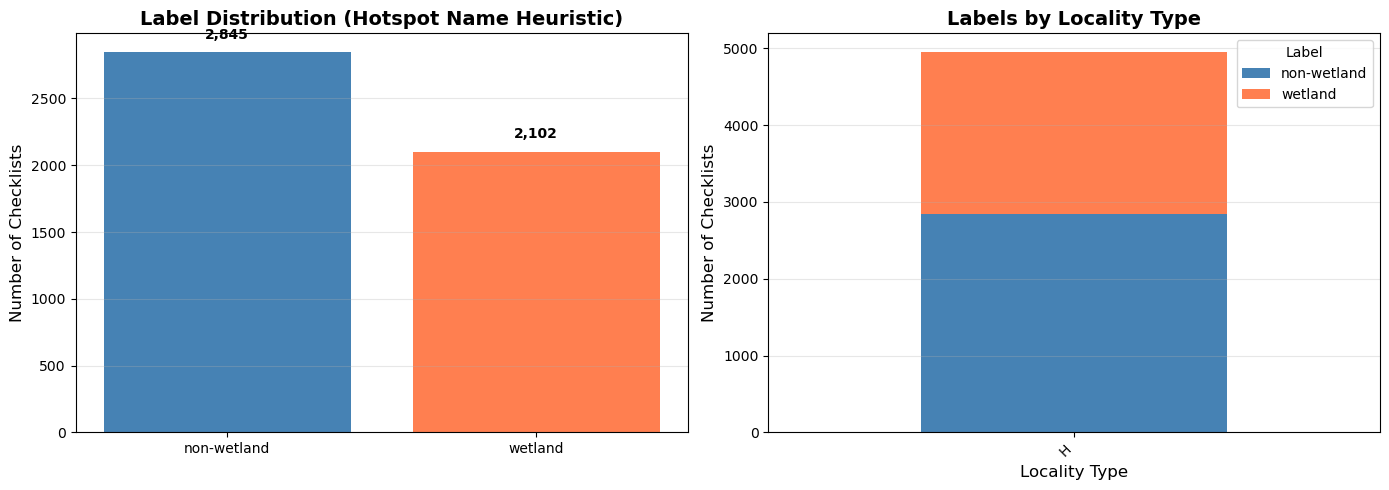

In [50]:
# Plot label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Label counts
label_counts = final_df['label'].value_counts()
axes[0].bar(label_counts.index, label_counts.values, color=['steelblue', 'coral'])
axes[0].set_ylabel('Number of Checklists', fontsize=12)
axes[0].set_title('Label Distribution (Hotspot Name Heuristic)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

# Locality type distribution
locality_dist = final_df.groupby(['LOCALITY_TYPE', 'label']).size().unstack(fill_value=0)
locality_dist.plot(kind='bar', stacked=True, ax=axes[1], color=['steelblue', 'coral'])
axes[1].set_xlabel('Locality Type', fontsize=12)
axes[1].set_ylabel('Number of Checklists', fontsize=12)
axes[1].set_title('Labels by Locality Type', fontsize=14, fontweight='bold')
axes[1].legend(title='Label')
axes[1].grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Summary

In [51]:
print('='*70)
print('PREPROCESSING COMPLETE - HOTSPOT NAME HEURISTIC')
print('='*70)
print(f'\n📋 Method:')
print(f'   Hotspot name keyword matching')
print(f'   Wetland keywords: {len(WETLAND_KEYWORDS)}')
print(f'   Non-wetland keywords: {len(NON_WETLAND_KEYWORDS)}')
print(f'\n📊 Labeled Dataset:')
print(f'   Total checklists: {len(final_df):,}')
print(f'   Wetland: {(final_df["label"] == "wetland").sum():,}')
print(f'   Non-wetland: {(final_df["label"] == "non-wetland").sum():,}')
print(f'   Source: eBird hotspots only')
print(f'\n💾 Outputs:')
print(f'   NPZ: {save_path.name}')
print(f'   CSV: {csv_path.name}')
print(f'\n✨ Ready for Phase 1: Exploration!')
print('   Next: Run 01_exploration.ipynb (modify to use this dataset)')
print('='*70)

PREPROCESSING COMPLETE - HOTSPOT NAME HEURISTIC

📋 Method:
   Hotspot name keyword matching
   Wetland keywords: 35
   Non-wetland keywords: 29

📊 Labeled Dataset:
   Total checklists: 4,947
   Wetland: 2,102
   Non-wetland: 2,845
   Source: eBird hotspots only

💾 Outputs:
   NPZ: wetland_hotspot_labeled.npz
   CSV: wetland_hotspot_labeled.csv

✨ Ready for Phase 1: Exploration!
   Next: Run 01_exploration.ipynb (modify to use this dataset)
